In [60]:
%matplotlib inline
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pylab as plt
import statsmodels.formula.api as sm
from statsmodels.tsa import tsatools
from statsmodels.graphics import tsaplots
from statsmodels.tsa.holtwinters import ExponentialSmoothing

In [61]:
aw = pd.read_csv('AustralianWines.csv')

In [62]:
aw

,Month,Drywhite,Fortified,Red,Rose,Sparkling,Sweetwhite
0,1980-01,1954,2585,464,112.0,1686,85
1,1980-02,2302,3368,675,118.0,1591,89
2,1980-03,3054,3210,703,129.0,2304,109
3,1980-04,2414,3111,887,99.0,1712,95
4,1980-05,2226,3756,1139,116.0,1471,91
...,...,...,...,...,...,...,...
182,1995-03,4067,1818,2459,45.0,1897,188
183,1995-04,4022,2262,2618,52.0,1862,195
184,1995-05,3937,2612,2585,28.0,1670,189
185,1995-06,4365,2967,3310,40.0,1688,220


The forecasting method that would be suitable for all the series is Holt-Winter's exponential smoothing

In [63]:
tified = aw[['Month', 'Fortified']]

In [64]:
#convert to time series
tified['Month'] = pd.to_datetime(tified.Month, format = '%Y-%m')
Sales_ts = pd.Series(tified.Fortified.values, index = tified.Month, name = 'Sales')
Sales_ts.index = pd.DatetimeIndex(Sales_ts.index, freq = Sales_ts.index.inferred_freq)

C:\Users\GETHSEMAN\anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [65]:
nValid = 19
nTrain = len(Sales_ts) - nValid

#partition the data
train_ts = Sales_ts[:nTrain]
valid_ts = Sales_ts[nTrain:]

In [66]:
train_ts

Month
1980-01-01    2585
1980-02-01    3368
1980-03-01    3210
1980-04-01    3111
1980-05-01    3756
              ... 
1993-08-01    2626
1993-09-01    2132
1993-10-01    1772
1993-11-01    2526
1993-12-01    2755
Freq: MS, Name: Sales, Length: 168, dtype: int64

In [67]:
valid_ts

Month
1994-01-01    1154
1994-02-01    1568
1994-03-01    1965
1994-04-01    2659
1994-05-01    2354
1994-06-01    2592
1994-07-01    2714
1994-08-01    2294
1994-09-01    2416
1994-10-01    2016
1994-11-01    2799
1994-12-01    2467
1995-01-01    1153
1995-02-01    1482
1995-03-01    1818
1995-04-01    2262
1995-05-01    2612
1995-06-01    2967
1995-07-01    3179
Freq: MS, Name: Sales, dtype: int64

C:\Users\GETHSEMAN\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters.py:725: RuntimeWarning: invalid value encountered in less_equal
  loc = initial_p <= lb
C:\Users\GETHSEMAN\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters.py:731: RuntimeWarning: invalid value encountered in greater_equal
  loc = initial_p >= ub


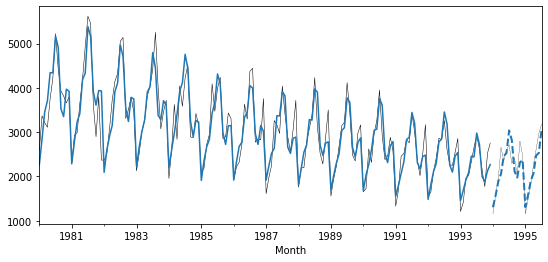

In [68]:
# run exponential smoothing with additive trend and multiplicative seasonality
expSmooth = ExponentialSmoothing(train_ts, trend='additive', seasonal='multiplicative', seasonal_periods=12, freq='MS')
expSmoothFit = expSmooth.fit(smoothing_level = 0.2, smoothing_slope = 0.15, smoothing_seasonal = 0.05)

fig, ax = plt.subplots(figsize=(9,4))
train_ts.plot(ax=ax, color='black', linewidth=0.5)
valid_ts.plot(ax=ax, color='black', linewidth=0.25)

expSmoothFit.fittedvalues.plot(ax=ax)
expSmoothFit.forecast(len(valid_ts)).plot(ax=ax, style='--', linewidth=2, color='C0')


plt.show()

In [69]:
print(expSmoothFit.forecast(3))

1994-01-01    1304.431522
1994-02-01    1569.546378
1994-03-01    1890.327853
Freq: MS, dtype: float64


In [70]:
residual = valid_ts - expSmoothFit.forecast(len(valid_ts))

In [71]:
print(residual)

Month
1994-01-01   -150.431522
1994-02-01     -1.546378
1994-03-01     74.672147
1994-04-01    600.739766
1994-05-01   -109.075809
1994-06-01     69.608051
1994-07-01   -325.185202
1994-08-01   -524.653457
1994-09-01    299.015311
1994-10-01     42.244434
1994-11-01    482.981753
1994-12-01     94.381942
1995-01-01   -155.511596
1995-02-01    -92.454414
1995-03-01    -78.237445
1995-04-01    197.306855
1995-05-01    141.228068
1995-06-01    436.728641
1995-07-01    130.323508
Freq: MS, dtype: float64


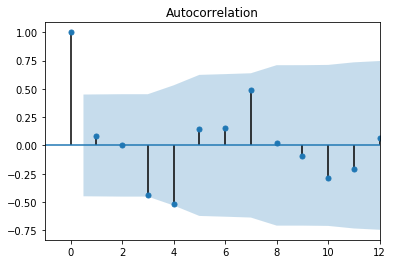

In [74]:
tsaplots.plot_acf(residual)
plt.xlim(-1, 12)
plt.show()

This model does not capture the seasonality well. This can possibly be handled well by first fitting a regression model with trend and seasonality.